# Gnerate Synthetic Dataset

In [1]:
import random
import pandas as pd

# Define templates and sentiment words
templates = [
    "I [user_verb] this product because it [product_verb] my expectations.",
    "The quality was [adjective], and I would [user_verb] recommend it.",
    "This product is [adjective]. Definitely [user_verb] it to anyone!",
    "I found this product to be [adjective], and it [product_verb] my needs.",
]

positive_words = ["amazing", "great", "perfect", "excellent", "loved"]
negative_words = ["terrible", "bad", "poor", "horrible", "disappointing"]

# Verbs that describe user feelings
user_verbs_positive = ["love", "like", "appreciate", "enjoy"]
user_verbs_negative = ["dislike", "hate", "avoid", "regret"]

# Verbs that describe product performance
product_verbs_positive = ["exceeded", "met", "fulfilled", "impressed"]
product_verbs_negative = ["fell short of", "failed to", "disappointed", "lacked"]


# Generate synthetic review
def generate_review(sentiment="positive"):
    template = random.choice(templates)
    if sentiment == "positive":
        review = template.replace("[adjective]", random.choice(positive_words))
        review = review.replace("[user_verb]", random.choice(user_verbs_positive))
        review = review.replace("[product_verb]", random.choice(product_verbs_positive))
    else:
        review = template.replace("[adjective]", random.choice(negative_words))
        review = review.replace("[user_verb]", random.choice(user_verbs_negative))
        review = review.replace("[product_verb]", random.choice(product_verbs_negative))
    return review


# Generate synthetic dataset
def generate_synthetic_dataset(num_samples=1000):
    data = []
    for _ in range(num_samples):
        sentiment = random.choice(["positive", "negative"])
        review = generate_review(sentiment=sentiment)
        label = 1 if sentiment == "positive" else 0
        data.append({"Review Text": review, "Recommended IND": label})
    return data


# Create and save synthetic dataset
synthetic_data = generate_synthetic_dataset(num_samples=2000)
synthetic_df = pd.DataFrame(synthetic_data)
synthetic_df.to_csv("data/synthetic_reviews.csv", index=False)
print("Synthetic dataset saved to 'synthetic_reviews.csv'")

Synthetic dataset saved to 'synthetic_reviews.csv'


#  Train Model on Synthetic Data

In [2]:
# Import required libraries for model training
import torch
from transformers import BertTokenizer, BertForSequenceClassification
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score

# Load synthetic dataset
data = pd.read_csv("data/synthetic_reviews.csv")
print(f"Loaded synthetic data with {len(data)} samples")

# Split data into train/test
train_texts, val_texts, train_labels, val_labels = train_test_split(
    data["Review Text"], data["Recommended IND"], test_size=0.1, random_state=42
)

# Tokenize data
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

train_encodings = tokenizer(
    list(train_texts), truncation=True, padding=True, max_length=128
)
val_encodings = tokenizer(
    list(val_texts), truncation=True, padding=True, max_length=128
)


# Prepare PyTorch Dataset
class ReviewDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels.reset_index(drop=True)

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item["labels"] = torch.tensor(self.labels.iloc[idx])
        return item

    def __len__(self):
        return len(self.labels)


train_dataset = ReviewDataset(train_encodings, train_labels)
val_dataset = ReviewDataset(val_encodings, val_labels)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

# Load pre-trained BERT model
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model.to(device)

# Define optimizer and scheduler
from transformers import AdamW, get_linear_schedule_with_warmup

optimizer = AdamW(model.parameters(), lr=5e-5)
total_steps = len(train_loader) * 3  # Number of epochs = 3

scheduler = get_linear_schedule_with_warmup(
    optimizer, num_warmup_steps=0, num_training_steps=total_steps
)

# Define loss function
from torch.nn import CrossEntropyLoss

loss_fn = CrossEntropyLoss()

# Train the model
epochs = 3
for epoch in range(epochs):
    model.train()
    total_train_loss = 0

    for batch in train_loader:
        optimizer.zero_grad()
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        outputs = model(
            input_ids=input_ids, attention_mask=attention_mask, labels=labels
        )
        loss = outputs.loss
        total_train_loss += loss.item()
        loss.backward()
        optimizer.step()
        scheduler.step()

    print(
        f"Epoch {epoch+1}/{epochs}, Training Loss: {total_train_loss / len(train_loader)}"
    )

# Evaluate the model
model.eval()
predictions, true_labels = [], []
with torch.no_grad():
    for batch in val_loader:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits

        predictions.extend(torch.argmax(logits, dim=1).cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

# Print classification report
print(
    classification_report(
        true_labels, predictions, target_names=["Not Recommend", "Recommend"]
    )
)

Loaded synthetic data with 2000 samples


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/opt/miniconda3/lib/python3.12/site-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/3, Training Loss: 0.05888887278506928
Epoch 2/3, Training Loss: 0.0005203243937401052
Epoch 3/3, Training Loss: 0.00035971724551863376
               precision    recall  f1-score   support

Not Recommend       1.00      1.00      1.00       104
    Recommend       1.00      1.00      1.00        96

     accuracy                           1.00       200
    macro avg       1.00      1.00      1.00       200
 weighted avg       1.00      1.00      1.00       200



# Good and Bad Performance Examples

In [10]:
def evaluate_and_extract(loader, model, device):
    model.eval()
    results = []
    with torch.no_grad():
        for batch in loader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)

            # Predict
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            predicted_labels = torch.argmax(logits, dim=1).cpu().numpy()

            # Add results for the batch
            results.extend(
                {
                    "Review Text": tokenizer.decode(
                        input_ids[i], skip_special_tokens=True
                    ),
                    "True Label": labels.cpu().numpy()[i],
                    "Predicted Label": predicted_labels[i],
                }
                for i in range(len(predicted_labels))
            )
    return results


# Evaluate the model and collect results
results = evaluate_and_extract(val_loader, model, device)

synthetic_results_df = pd.DataFrame(results)

# Separate good and poor performance
good_performance = synthetic_results_df[
    synthetic_results_df["True Label"] == synthetic_results_df["Predicted Label"]
]
poor_performance = synthetic_results_df[
    synthetic_results_df["True Label"] != synthetic_results_df["Predicted Label"]
]

# Display examples
print("Good Performance Examples:")
print(good_performance[["Review Text", "True Label", "Predicted Label"]].sample(3))

print("Poor Performance Examples:")
print(poor_performance[["Review Text", "True Label", "Predicted Label"]].head(3))

Good Performance Examples:
                                           Review Text  True Label  \
136  this product is loved. definitely appreciate i...           1   
19   i found this product to be terrible, and it fa...           0   
140  i enjoy this product because it fulfilled my e...           1   

     Predicted Label  
136                1  
19                 0  
140                1  
Poor Performance Examples:
Empty DataFrame
Columns: [Review Text, True Label, Predicted Label]
Index: []


# Comparison Table

In [4]:
# Updated metrics from the evaluations
metrics_data = {
    "Metric": [
        "Accuracy",
        "Precision (Not Recommend)",
        "Precision (Recommend)",
        "Recall (Not Recommend)",
        "Recall (Recommend)",
        "F1-Score (Not Recommend)",
        "F1-Score (Recommend)",
    ],
    "Synthetic Data": [1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00],
    "Real Data": [0.91, 0.79, 0.94, 0.73, 0.96, 0.76, 0.95],
}

# Create a DataFrame
comparison_df = pd.DataFrame(metrics_data)

# Display the table
print(comparison_df)

                      Metric  Synthetic Data  Real Data
0                   Accuracy             1.0       0.91
1  Precision (Not Recommend)             1.0       0.79
2      Precision (Recommend)             1.0       0.94
3     Recall (Not Recommend)             1.0       0.73
4         Recall (Recommend)             1.0       0.96
5   F1-Score (Not Recommend)             1.0       0.76
6       F1-Score (Recommend)             1.0       0.95


# Comparison Chart

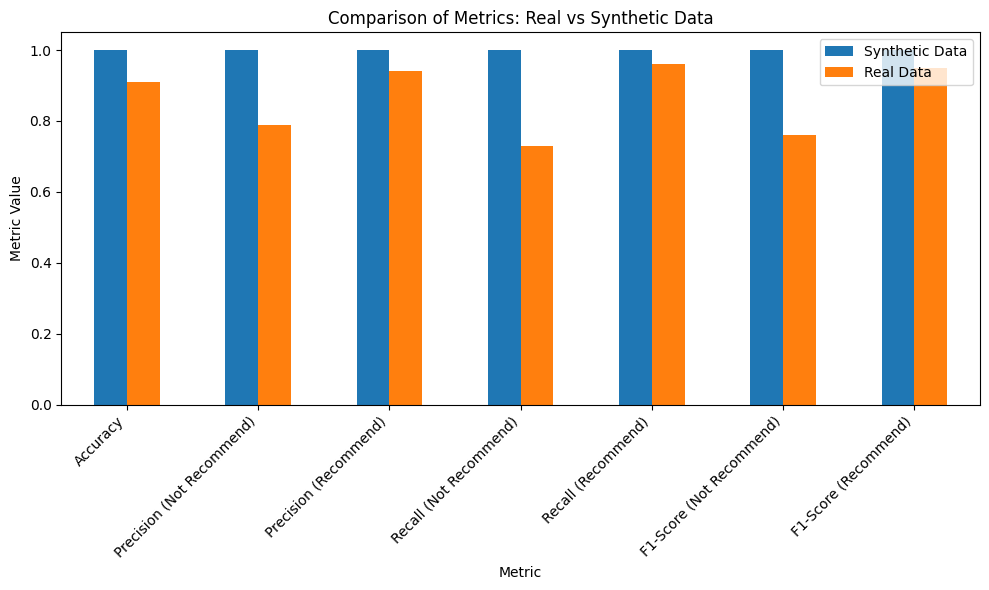

In [5]:
import matplotlib.pyplot as plt

# Plot comparison
comparison_df.set_index("Metric").plot(kind="bar", figsize=(10, 6))
plt.title("Comparison of Metrics: Real vs Synthetic Data")
plt.ylabel("Metric Value")
plt.xticks(rotation=45, ha="right")
plt.legend(loc="upper right")
plt.tight_layout()
plt.show()